In [1]:
!apt-get -y install google-chrome-stable

Reading package lists... Done
Building dependency tree       
Reading state information... Done
google-chrome-stable is already the newest version (98.0.4758.102-1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [2]:
chrome_driver_version = !curl -get http://chromedriver.storage.googleapis.com/LATEST_RELEASE
chrome_driver_version = chrome_driver_version[-1]
url = f'http://chromedriver.storage.googleapis.com/{chrome_driver_version}/chromedriver_linux64.zip'
url

'http://chromedriver.storage.googleapis.com/98.0.4758.102/chromedriver_linux64.zip'

In [3]:
!wget -O /tmp/chromedriver.zip $url

--2022-02-28 07:03:24--  http://chromedriver.storage.googleapis.com/98.0.4758.102/chromedriver_linux64.zip
Resolving chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)... 34.64.4.16, 2404:f340:10:1803::2010
Connecting to chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)|34.64.4.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10229802 (9.8M) [application/zip]
Saving to: ‘/tmp/chromedriver.zip’

/tmp/chromedriver.z 100%[===================>]   9.76M  6.89MB/s    in 1.4s    

2022-02-28 07:03:26 (6.89 MB/s) - ‘/tmp/chromedriver.zip’ saved [10229802/10229802]



In [4]:
!unzip -o /tmp/chromedriver.zip chromedriver -d /usr/local/bin/

Archive:  /tmp/chromedriver.zip
  inflating: /usr/local/bin/chromedriver  


In [5]:
import pandas as pd 
import os
from hanspell import spell_checker
import requests
from urllib import parse
import json
from multiprocessing.dummy import Process, Queue, Pool, Manager
import math
import re
from time import process_time, sleep
from ckonlpy.tag import Twitter
from nltk import ngrams
from os import getpid
from selenium import webdriver
from IPython import display
from base64 import b64decode
from google.cloud import vision
import io
from PIL import Image
import csv
import uuid
import time

In [6]:
schoolNoticeListPath = './train_data'
schoolNoticeListPath = os.path.join(schoolNoticeListPath, 'school-notice.csv')
schoolNoticeListPath

'./train_data/school-notice.csv'

In [7]:
schoolNoticeList = pd.read_csv(schoolNoticeListPath)
schoolNoticeList.head()

,idx,url,category,date
0,5298,https://web.kangnam.ac.kr/menu/board/info/f190...,학습/상담,22.02.28
1,5297,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.28
2,5296,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.27
3,5295,https://web.kangnam.ac.kr/menu/board/info/f190...,장학,22.02.25
4,5294,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25


In [8]:
schoolNoticeList.dtypes

idx          int64
url         object
category    object
date        object
dtype: object

In [9]:
schoolNoticeList.size

21192

In [10]:
options = webdriver.chrome.options.Options()
options.add_argument("--no-sandbox")
options.add_argument("--disable-setuid-sandbox")
options.add_argument("--disable-extensions")
options.add_argument('headless')
options.add_argument('window-size=1920x1080')
options.add_argument("disable-gpu")
driver = webdriver.Chrome(chrome_options=options)

driver.get("https://httpstat.us/200")

if "200 OK" in driver.page_source:
    print('Selenium successfully opened with Chrome (under the Xvfb display) and navigated to "https://httpstat.us/200", you\'re all set!')
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


Selenium successfully opened with Chrome (under the Xvfb display) and navigated to "https://httpstat.us/200", you're all set!


In [11]:
url = schoolNoticeList['url'][0]
url

'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=False&encMenuSeq=b46b6e20bc53a0234ac9fc9a238b113a&encMenuBoardSeq=39b3e9dcb9fc1c0bb4fb49abf52ebaca'

In [12]:
driver.get(url)

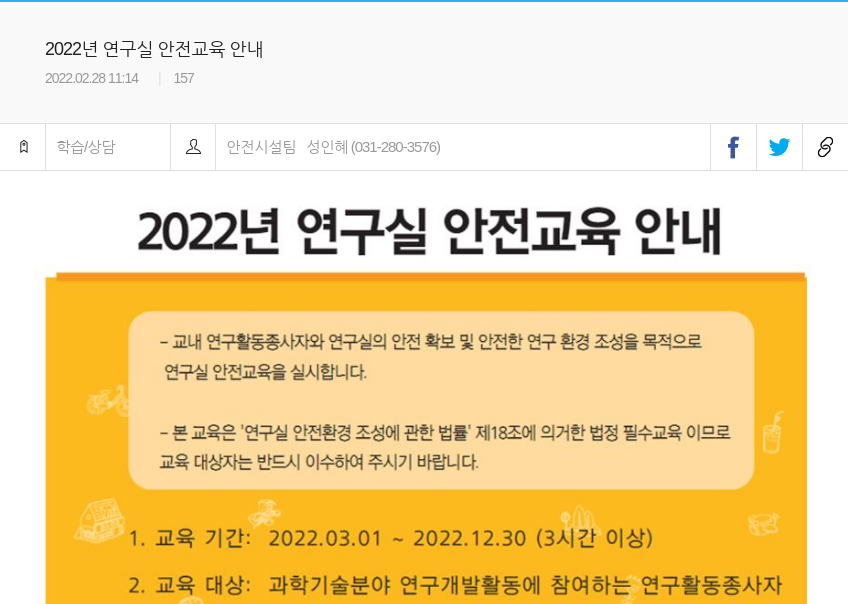

In [13]:
assert driver.page_source is not None
content = driver.find_element_by_css_selector('#sub_content_wrap > div > div > div.col-xs-12.col-md-9 > div > div.cont > div > div > div.ul_respon.tbl_wtite.tbl_write02')
display.Image(b64decode(content.screenshot_as_base64))

In [14]:
body = content.find_element_by_css_selector('div.tbody > ul:nth-child(2)')
body.get_attribute('innerHTML')#sub_content_wrap > div > div > div.col-xs-12.col-md-9 > div > div.cont > div > div > div.ul_respon.tbl_wtite.tbl_write02 > 

'<li class="first last odd li_index0 li_respon w100"><div class="inner_txt"><div class="tbl_view cke_editable cke_editable_themed cke_contents_ltr"><p class="contents_add_one1" style="display:none;">연구실 안전교육</p><p class="contents_add_one2" style="display:none;">안전시설팀</p><p><img alt="" src="/comm/cmnFile/image.do?encSvrFileNm=505d616b62e9cf71e0c8acd58f452006bb1f0cdaee5b57e7704b295729ff8e4bdbe35af3bfecaa94becbad2c752178036043010e95760db1d231ae65fe723180"></p><p>&nbsp;</p></div></div></li>'

In [15]:
body.text.strip()

''

In [16]:
'img' in body.get_attribute('innerHTML')

True

In [17]:
img_list = [img_tag.get_attribute('src') for img_tag in body.find_elements_by_css_selector('img')]
img_list

['https://web.kangnam.ac.kr/comm/cmnFile/image.do?encSvrFileNm=505d616b62e9cf71e0c8acd58f452006bb1f0cdaee5b57e7704b295729ff8e4bdbe35af3bfecaa94becbad2c752178036043010e95760db1d231ae65fe723180']

In [18]:
'base64' in img_list[0]

False

In [19]:
schoolNoticeSrcListPath = os.path.join('./train_data/src', f'{uuid.uuid1()}.png')
os.makedirs('./train_data/src', exist_ok=True)
img_data = requests.get(img_list[0]).content
with open(schoolNoticeSrcListPath, 'wb') as handler:
    handler.write(img_data)

In [20]:
def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·\s]', '', inputString)
    return text_rmv

In [21]:
def export_notice_text(body):
    return clean_text(body.text.strip())

In [22]:
def export_title_text(body):
    return clean_text(body.find_element_by_css_selector('div.tblw_subj.nanum').text.strip())

In [23]:
train_data_src = './train_data/src'
os.makedirs(train_data_src, exist_ok=True)

def export_notice_img_list(body):
    img_saved_path_list = []
    if 'img' in body.get_attribute('innerHTML'):
        img_list = [img_tag.get_attribute('src') for img_tag in body.find_elements_by_css_selector('img')]
#         print('img_list', img_list)
        for img_src in img_list:
            srcPath = os.path.join(train_data_src, f'{uuid.uuid1()}.png')
#             print(srcPath, img_saved_path_list)
            if 'base64' in img_src:
#                 print('append?', img_saved_path_list.append(srcPath), img_saved_path_list)
                with open(srcPath, "wb") as f:
                    f.write(b64decode(re.search(r'base64,(.*)', img_src).group(1)))
                img_saved_path_list.append(srcPath)
#                 print(srcPath, img_saved_path_list)
            else:
                img_data = requests.get(img_src).content
                with open(srcPath, 'wb') as handler:
                    handler.write(img_data)
                img_saved_path_list.append(srcPath)
#                 print(srcPath, img_saved_path_list)
    return img_saved_path_list

In [24]:
def export_notice_data(driver, url, idx = None):
    if driver is None or url is None:
        print(f'idx: {idx}, driver or url is None')
        return (idx, None, None, None)
    driver.get(url)
    
    if driver.page_source is None:
        print(f'idx: {idx}, page_source is None')
        return (idx, None, None, None)
    
    content = driver.find_element_by_css_selector('#sub_content_wrap > div > div > div.col-xs-12.col-md-9 > div > div.cont > div > div > div.ul_respon.tbl_wtite.tbl_write02')
    
    body = content.find_element_by_css_selector('div.tbody > ul:nth-child(2)')
#     print(content.text, 'body', body.text)
    return (idx, export_title_text(content), export_notice_text(body), export_notice_img_list(body))

In [25]:
assert len(export_notice_data(driver, 'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=false&encMenuSeq=c5dc4b1d7b4dd402e5e6a7a8471eb55c&encMenuBoardSeq=1db853c16158bdae31c09d146d4571dc')[3]) == 4
assert len (export_notice_data(driver, 'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=false&encMenuSeq=b46b6e20bc53a0234ac9fc9a238b113a&encMenuBoardSeq=39b3e9dcb9fc1c0bb4fb49abf52ebaca')[3]) == 1

In [26]:
result = export_notice_data(driver, 'https://web.kangnam.ac.kr/menu/board/info/f19069e6134f8f8aa7f689a4a675e66f.do?scrtWrtiYn=false&encMenuSeq=c5dc4b1d7b4dd402e5e6a7a8471eb55c&encMenuBoardSeq=a9e53dcab66d25012cdc87c13d1c9c1d')

assert (None, len(result[1]), len(result[2]), len(result[3])) == (None, 26, 845, 0)

In [27]:
schoolNoticeList[:10]

,idx,url,category,date
0,5298,https://web.kangnam.ac.kr/menu/board/info/f190...,학습/상담,22.02.28
1,5297,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.28
2,5296,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.27
3,5295,https://web.kangnam.ac.kr/menu/board/info/f190...,장학,22.02.25
4,5294,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25
5,5293,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25
6,5292,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.25
7,5291,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.24
8,5290,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.24
9,5289,https://web.kangnam.ac.kr/menu/board/info/f190...,학사,22.02.23


In [28]:
t1_start = time.perf_counter()
for idx in range(10):
    export_notice_data(driver, schoolNoticeList['url'][idx], idx)
t1_stop = time.perf_counter()
takeTime = round(t1_stop - t1_start, 2)
print(f'time: {takeTime:>8}s')

time:     9.44s


In [37]:
reqNum = 5
driver_pool = []

for idx in range(reqNum):
    options = webdriver.chrome.options.Options()
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-setuid-sandbox")
    options.add_argument("--disable-extensions")
    options.add_argument('headless')
    options.add_argument('window-size=1920x1080')
    options.add_argument("disable-gpu")
    driver = webdriver.Chrome(chrome_options=options)
    driver_pool.append(driver)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':


In [38]:
processQueue = Queue()
while not processQueue.empty():
    try:
        processQueue.get(False)
    except Empty:
        continue
#     processQueue.task_done()
processQueue.qsize()

0

In [39]:
lastProcessPercentage = 0
dataSize = len(schoolNoticeList['idx'])
t1_start = time.perf_counter()
debug = True
offset = 0
TIMEOUT = 10

for pid in range(math.ceil(dataSize / reqNum)):
    start = pid * reqNum + 1 + offset
    
    if (start / dataSize) * 100 - lastProcessPercentage > 5:
        lastProcessPercentage = round((start / dataSize) * 100, 2)
        t1_stop = time.perf_counter()
        takeTime = round(t1_stop - t1_start, 2)
        print(f'process...{lastProcessPercentage:>6}% time: {takeTime:>8}s')
    
    if start + reqNum > dataSize:
        end = dataSize + 1
    else:
        end = start + reqNum
    processList = []
    print(f'{start:>5} ~ {end:>5} start!') if debug else None
    with Pool(processes=reqNum) as pool:
#         print('pool start')
        results = [pool.apply_async(export_notice_data, (driver_pool[idx % reqNum], schoolNoticeList['url'][idx], idx)) for idx in range(start, end)]
#         print('result ')
#         sleep(TIMEOUT)
#         pool.terminate()
#         print('terminate', len(results))
        for idx in range(len(results)):
#             print(results[idx].get())
            processQueue.put(results[idx].get())
#         [print(res.get()) for res in results]#processQueue.put
#         print('send queue')
#         print(results[0].get())
    print(f'{start:>5} ~ {end:>5} done! queue size: {processQueue.qsize()}') if debug else None

t1_stop = time.perf_counter()
takeTime = round(t1_stop - t1_start, 2)
print(f'process...100% time: {takeTime:>8}s')

    1 ~     6 start!
    1 ~     6 done! queue size: 5
    6 ~    11 start!
    6 ~    11 done! queue size: 10
   11 ~    16 start!
   11 ~    16 done! queue size: 15
   16 ~    21 start!
   16 ~    21 done! queue size: 20
   21 ~    26 start!
   21 ~    26 done! queue size: 25
   26 ~    31 start!
   26 ~    31 done! queue size: 30
   31 ~    36 start!
   31 ~    36 done! queue size: 35
   36 ~    41 start!
   36 ~    41 done! queue size: 40
   41 ~    46 start!
   41 ~    46 done! queue size: 45
   46 ~    51 start!
   46 ~    51 done! queue size: 50
   51 ~    56 start!
   51 ~    56 done! queue size: 55
   56 ~    61 start!
   56 ~    61 done! queue size: 60
   61 ~    66 start!
   61 ~    66 done! queue size: 65
   66 ~    71 start!
   66 ~    71 done! queue size: 70
   71 ~    76 start!
   71 ~    76 done! queue size: 75
   76 ~    81 start!
   76 ~    81 done! queue size: 80
   81 ~    86 start!
   81 ~    86 done! queue size: 85
   86 ~    91 start!
   86 ~    91 done! queue si

  716 ~   721 done! queue size: 720
  721 ~   726 start!
  721 ~   726 done! queue size: 725
  726 ~   731 start!
  726 ~   731 done! queue size: 730
  731 ~   736 start!
  731 ~   736 done! queue size: 735
  736 ~   741 start!
  736 ~   741 done! queue size: 740
  741 ~   746 start!
  741 ~   746 done! queue size: 745
  746 ~   751 start!
  746 ~   751 done! queue size: 750
  751 ~   756 start!
  751 ~   756 done! queue size: 755
  756 ~   761 start!
  756 ~   761 done! queue size: 760
  761 ~   766 start!
  761 ~   766 done! queue size: 765
  766 ~   771 start!
  766 ~   771 done! queue size: 770
  771 ~   776 start!
  771 ~   776 done! queue size: 775
  776 ~   781 start!
  776 ~   781 done! queue size: 780
  781 ~   786 start!
  781 ~   786 done! queue size: 785
  786 ~   791 start!
  786 ~   791 done! queue size: 790
  791 ~   796 start!
  791 ~   796 done! queue size: 795
process... 15.02% time:   628.69s
  796 ~   801 start!
  796 ~   801 done! queue size: 800
  801 ~   806 star

 1421 ~  1426 done! queue size: 1425
 1426 ~  1431 start!
 1426 ~  1431 done! queue size: 1430
 1431 ~  1436 start!
 1431 ~  1436 done! queue size: 1435
 1436 ~  1441 start!
 1436 ~  1441 done! queue size: 1440
 1441 ~  1446 start!
 1441 ~  1446 done! queue size: 1445
 1446 ~  1451 start!
 1446 ~  1451 done! queue size: 1450
 1451 ~  1456 start!
 1451 ~  1456 done! queue size: 1455
 1456 ~  1461 start!
 1456 ~  1461 done! queue size: 1460
 1461 ~  1466 start!
 1461 ~  1466 done! queue size: 1465
 1466 ~  1471 start!
 1466 ~  1471 done! queue size: 1470
 1471 ~  1476 start!
 1471 ~  1476 done! queue size: 1475
 1476 ~  1481 start!
 1476 ~  1481 done! queue size: 1480
 1481 ~  1486 start!
 1481 ~  1486 done! queue size: 1485
 1486 ~  1491 start!
 1486 ~  1491 done! queue size: 1490
 1491 ~  1496 start!
 1491 ~  1496 done! queue size: 1495
 1496 ~  1501 start!
 1496 ~  1501 done! queue size: 1500
 1501 ~  1506 start!
 1501 ~  1506 done! queue size: 1505
 1506 ~  1511 start!
 1506 ~  1511 

 2126 ~  2131 done! queue size: 2130
process... 40.22% time:  1922.87s
 2131 ~  2136 start!
 2131 ~  2136 done! queue size: 2135
 2136 ~  2141 start!
 2136 ~  2141 done! queue size: 2140
 2141 ~  2146 start!
 2141 ~  2146 done! queue size: 2145
 2146 ~  2151 start!
 2146 ~  2151 done! queue size: 2150
 2151 ~  2156 start!
 2151 ~  2156 done! queue size: 2155
 2156 ~  2161 start!
 2156 ~  2161 done! queue size: 2160
 2161 ~  2166 start!
 2161 ~  2166 done! queue size: 2165
 2166 ~  2171 start!
 2166 ~  2171 done! queue size: 2170
 2171 ~  2176 start!
 2171 ~  2176 done! queue size: 2175
 2176 ~  2181 start!
 2176 ~  2181 done! queue size: 2180
 2181 ~  2186 start!
 2181 ~  2186 done! queue size: 2185
 2186 ~  2191 start!
 2186 ~  2191 done! queue size: 2190
 2191 ~  2196 start!
 2191 ~  2196 done! queue size: 2195
 2196 ~  2201 start!
 2196 ~  2201 done! queue size: 2200
 2201 ~  2206 start!
 2201 ~  2206 done! queue size: 2205
 2206 ~  2211 start!
 2206 ~  2211 done! queue size: 2210
 

WebDriverException: Message: unknown error: session deleted because of page crash
from unknown error: cannot determine loading status
from tab crashed
  (Session info: headless chrome=98.0.4758.102)


In [35]:
driver_pool
for driver in driver_pool:
    driver.close()

In [36]:
while not processQueue.empty():
    data = processQueue.get(0)
    print(data)

(1, '교목실20221학기온라인학생채플일정', '', ['./train_data/src/b79cdcb6-9864-11ec-98fb-0242ac120002.png'])
(2, '20221학기학부및대학원재학생추가1차등록기간안내', '20221학기학부대학원재학생추가1차등록기간안내1등록기간가재학생학부대학원일시납추가1차20220302수0304금가상계좌송금매일17시마감나재학생학부대학원분납1차20220302수0304금가상계좌송금매일17시마감다학부9학기초과학점등록생20220314월0317목가상계좌송금매일17시마감2등록방법종합정보로그인→등록관리→등록금고지서출력→은행창구직접납부또는고지서상의가상계좌로송금3납부은행KB국민은행전국지점4등록금납부확인종합정보시스템로그인→기본정보조회→등록조회화면에서확인등록금을납부한다음날부터확인가능5등록금납입영수증이필요한경우가종합정보로그인→등록관리→교육비납입증명서→교육비납입확인서출력나학교홈페이지→자주찾는서비스→인터넷증명발급다교학팀에서교육비납입확인서를신청교학1팀샬롬관1층☏0312803412교학2팀경천관1층☏03128034424대학원교학팀샬롬관10층☏031280347134762022년연말정산용교육비납입증명서는2023년1월부터가능6기타사항가전액학비감면을받는경우실납부금0원에도꼭등록기간에납부절차를완료하여야합니다<실납부금액0원등록방법>1고지서를지참하여KB국민은행에방문하여창구또는ATM기로등록금납부처리2KB국민은행인터넷뱅킹로그인–공과금납부–대학등록금납부–학교학번가상계좌번호입력0원납부처리나등록금고지서에있는가상계좌는개인별로부여된계좌번호이므로예금주는학생본인입니다따라서입금자의명의와상관없이등록금을가상계좌에입금하면등록처리됩니다다등록금납부장학금및학자금대출관련문의처①등록금납부방법문의회계경리팀0312803563②학부장학금및학자금대출관련문의장학복지팀03128035512③대학원장학금및학자금대출관련문의대학원교학팀0312803476정부지원학자금대출안내신청방법한국장학재단wwwkosafgokr에서온라인신청문의전화15992000한국장학재단콜센터총무처장', [])
(3, '교외_신청2022년1학기「

In [40]:
crawled_data_list = []
while not processQueue.empty():
    data = processQueue.get(0)
    crawled_data_list.append(data)
len(crawled_data_list)

2388

In [51]:
crawled_data_list[:5]

[(1,
  '교목실20221학기온라인학생채플일정',
  '',
  ['./train_data/src/f0adbd5e-9864-11ec-a642-0242ac120002.png']),
 (2,
  '20221학기학부및대학원재학생추가1차등록기간안내',
  '20221학기학부대학원재학생추가1차등록기간안내1등록기간가재학생학부대학원일시납추가1차20220302수0304금가상계좌송금매일17시마감나재학생학부대학원분납1차20220302수0304금가상계좌송금매일17시마감다학부9학기초과학점등록생20220314월0317목가상계좌송금매일17시마감2등록방법종합정보로그인→등록관리→등록금고지서출력→은행창구직접납부또는고지서상의가상계좌로송금3납부은행KB국민은행전국지점4등록금납부확인종합정보시스템로그인→기본정보조회→등록조회화면에서확인등록금을납부한다음날부터확인가능5등록금납입영수증이필요한경우가종합정보로그인→등록관리→교육비납입증명서→교육비납입확인서출력나학교홈페이지→자주찾는서비스→인터넷증명발급다교학팀에서교육비납입확인서를신청교학1팀샬롬관1층☏0312803412교학2팀경천관1층☏03128034424대학원교학팀샬롬관10층☏031280347134762022년연말정산용교육비납입증명서는2023년1월부터가능6기타사항가전액학비감면을받는경우실납부금0원에도꼭등록기간에납부절차를완료하여야합니다<실납부금액0원등록방법>1고지서를지참하여KB국민은행에방문하여창구또는ATM기로등록금납부처리2KB국민은행인터넷뱅킹로그인–공과금납부–대학등록금납부–학교학번가상계좌번호입력0원납부처리나등록금고지서에있는가상계좌는개인별로부여된계좌번호이므로예금주는학생본인입니다따라서입금자의명의와상관없이등록금을가상계좌에입금하면등록처리됩니다다등록금납부장학금및학자금대출관련문의처①등록금납부방법문의회계경리팀0312803563②학부장학금및학자금대출관련문의장학복지팀03128035512③대학원장학금및학자금대출관련문의대학원교학팀0312803476정부지원학자금대출안내신청방법한국장학재단wwwkosafgokr에서온라인신청문의전화15992000한국장학재단콜센터총무처장',
  []),
 (3

In [54]:
crawled_data_list[-5:]

[(2384,
  '2019년5월820일성폭력예방교육장소공지',
  '2019년5월성폭력예방교육장소공지ㅁ마음나눔센터양성평등상담부에서는2019학년성폭력예방교육을다음과같이실시하오니학생들은참고하여참척하기바랍니다1교육일정no일시시간장소120190508수13001400샬롬관B108호220190520월11001200샬롬관B108호2교육대상MT졸업여행등단체행사참여학생연1회필수요청학과학생단체접수3신청방법1이메일신청knucckangnamackr단체신청시단체신청양식붙임파일작성개인신청시개인신청양식작성하여신청2전화신청03189972007205이름학번학과연락처4기타문의담당자김지연8997200',
  []),
 (2385,
  'CTL★5월학습법특강Day안내',
  'PC로신청학습법특강신청하러가기<<<클릭채팅상담바로가기<<<클릭',
  ['./train_data/src/f8975f98-9869-11ec-9096-0242ac120002.png']),
 (2386,
  '◆취창업취창업지원센터5월프로그램안내',
  '',
  ['./train_data/src/fd5a5c6a-9869-11ec-b910-0242ac120002.png']),
 (2387,
  '취업2019학년도상반기면접시놉시스워크샵안내',
  '',
  ['./train_data/src/02ee636a-986a-11ec-937a-0242ac120002.png']),
 (2388,
  'CTL★공모전20191학기학습법공모전안내',
  '지난수상작보러가기<<<클릭공모전참여하러가기<<<클릭',
  ['./train_data/src/fd5a5c06-9869-11ec-a256-0242ac120002.png'])]

In [42]:
json_data = {}
json_data['notice'] = []

In [44]:
for crawl_data in crawled_data_list:
    json_data['notice'].append({
        'idx': crawl_data[0],
        'title': crawl_data[1],
        'body': crawl_data[2],
        'imgs': crawl_data[3]
    })

In [47]:
noticeSize = len(json_data['notice'])

In [49]:
with open(os.path.join('./train_data', f'notice-{noticeSize}.json'), 'w') as outfile:
    json.dump(json_data, outfile)